In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import pickle
import numpy as np
from tqdm import tqdm

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file('../matplotlibrc')

In [2]:
pc_run_name = 'ct_64_128Mpc_nopop2'
dc_run_name = 'ct_64_128Mpc_xray_noLX_nopop2'

In [10]:
run_names = [
    'ct_32_64Mpc_nopop2',
    'ct_32_64Mpc_xray_noLX_nopop2',
    'ct_32_64Mpc_xray_noLX_nopop2_newPSSFRD',
    'ct_32_64Mpc_xray_noLX_nopop2_newSFRD',
]
r_s = [np.load(f"../outputs/dm21cm/{rn}_records.npy", allow_pickle=True).item() for rn in run_names]
labels = ['21cmFAST', 'DM21cm old sfrd', 'DM21cm new PS', 'DM21cm new PS+ST']

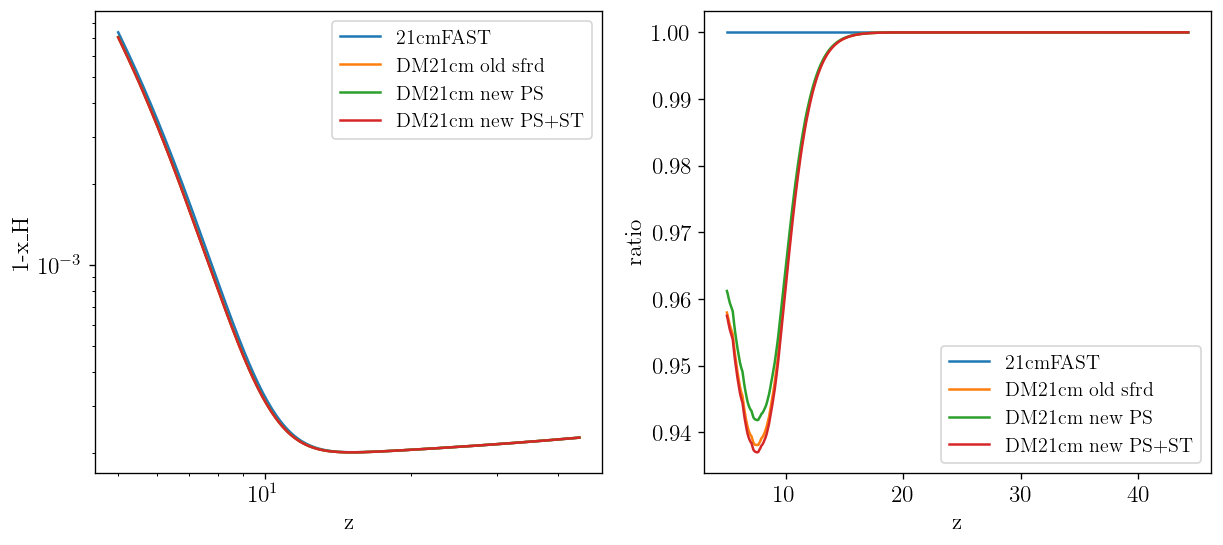

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

r0 = r_s[0]

for r, rn, l in zip(r_s, run_names, labels):
    ax = axs[0]
    ax.plot(r['z'], r['1-x_H'], label=l)
    ax = axs[1]
    ax.plot(r['z'], r['1-x_H']/r0['1-x_H'], label=l)
axs[0].set(xscale='log', yscale='log', xlabel='z', ylabel='1-x_H')
axs[0].legend()
axs[1].set(xlabel='z', ylabel='ratio')
axs[1].legend()

In [35]:
pc_run_name = 'xc'
dc_run_name = 'xc_xray_noLX'

In [3]:
r_pc = np.load(f"../outputs/dm21cm/{pc_run_name}_records.npy", allow_pickle=True).item()
r_dc = np.load(f"../outputs/dm21cm/{dc_run_name}_records.npy", allow_pickle=True).item()

In [4]:
def plot_silces(i, k, plot_log=True, save_fn=None):

    fig, axs = plt.subplots(1, 4, figsize=(24, 7))

    z1 = r_pc[k][i]
    z2 = r_dc[k][i]
    if k == 'x_H_slice':
        z1 = 1-z1
        z2 = 1-z2
    z1mean = np.mean(z1)
    z2mean = np.mean(z2)
    if plot_log:
        z1 = np.log10(z1)
        z2 = np.log10(z2)
    vmin = np.min([np.quantile(z1, 0.02), np.quantile(z2, 0.02)])
    vmax = np.max([np.quantile(z1, 0.98), np.quantile(z2, 0.98)])

    ax = axs[0]
    im = ax.imshow(z1, origin='lower', vmin=vmin, vmax=vmax)
    ax.set_title(f"21cmFAST mean={z1mean:.3e}")

    ax = axs[1]
    ax.imshow(z2, origin='lower', vmin=vmin, vmax=vmax)
    ax.set_title(f"DM21cm mean={z2mean:.3e}")

    ax = axs[2]
    zdiff = z2-z1
    imdiff = ax.imshow(np.log10(np.clip(np.abs(zdiff), 1e-10, None)), origin='lower', cmap='binary')
    ax.set_title(f"$|$DM21cm-21cmFAST$|$")

    ax = axs[3]
    z = r_pc['delta_slice'][i]
    imdelta = ax.imshow(z, origin='lower', cmap='binary')
    ax.set_title(f"delta")

    # ax = axs[4]
    # z = r_pc['delta_slice'][i]
    # imcoll = ax.imshow(z>1.66, origin='lower', cmap='binary', vmin=0, vmax=1)
    # ax.set_title(f"delta$>$1.66? white=no")

    k_title = k if k != 'x_H_slice' else '1-x_H_slice'
    fig.suptitle(f"{k_title}, $z$={r_pc['z'][i]:.3f}, first two colorbars are log10")

    fig.colorbar(im, ax=axs[:2], orientation='horizontal', aspect=40)
    fig.colorbar(imdiff, ax=axs[2], orientation='horizontal', aspect=20)
    fig.colorbar(imdelta, ax=axs[3], orientation='horizontal', aspect=20)
    #fig.colorbar(imcoll, ax=axs[4], orientation='horizontal', aspect=20)

    if save_fn is not None:
        fig.savefig(save_fn)
        plt.close(fig)

In [13]:
def plot_silces_multi_runs(i, k, plot_log=True, save_fn=None):

    plot_n = len(r_s)

    fig, axs = plt.subplots(1, plot_n, figsize=(6*plot_n, 7))

    z_s = [r[k][i] for r in r_s]
    if k == 'x_H_slice':
        z_s = [1-z for z in z_s]
    z_mean_s = [np.mean(z) for z in z_s]
    if plot_log:
        z_s = [np.log10(z) for z in z_s]
    vmin = np.quantile(np.concatenate(z_s), 0.02)
    vmax = np.quantile(np.concatenate(z_s), 0.98)

    for i in range(plot_n):
        ax = axs[i]
        im = ax.imshow(z_s[i], origin='lower', vmin=vmin, vmax=vmax)
        ax.set_title(f"{labels[i]} mean={z_mean_s[i]:.3e}")

    k_title = k if k != 'x_H_slice' else '1-x_H_slice'
    fig.suptitle(f"{k_title}, $z$={r_s[0]['z'][i]:.3f}")
    fig.colorbar(im, ax=axs, orientation='horizontal', aspect=40)

    if save_fn is not None:
        fig.savefig(save_fn)
        plt.close(fig)

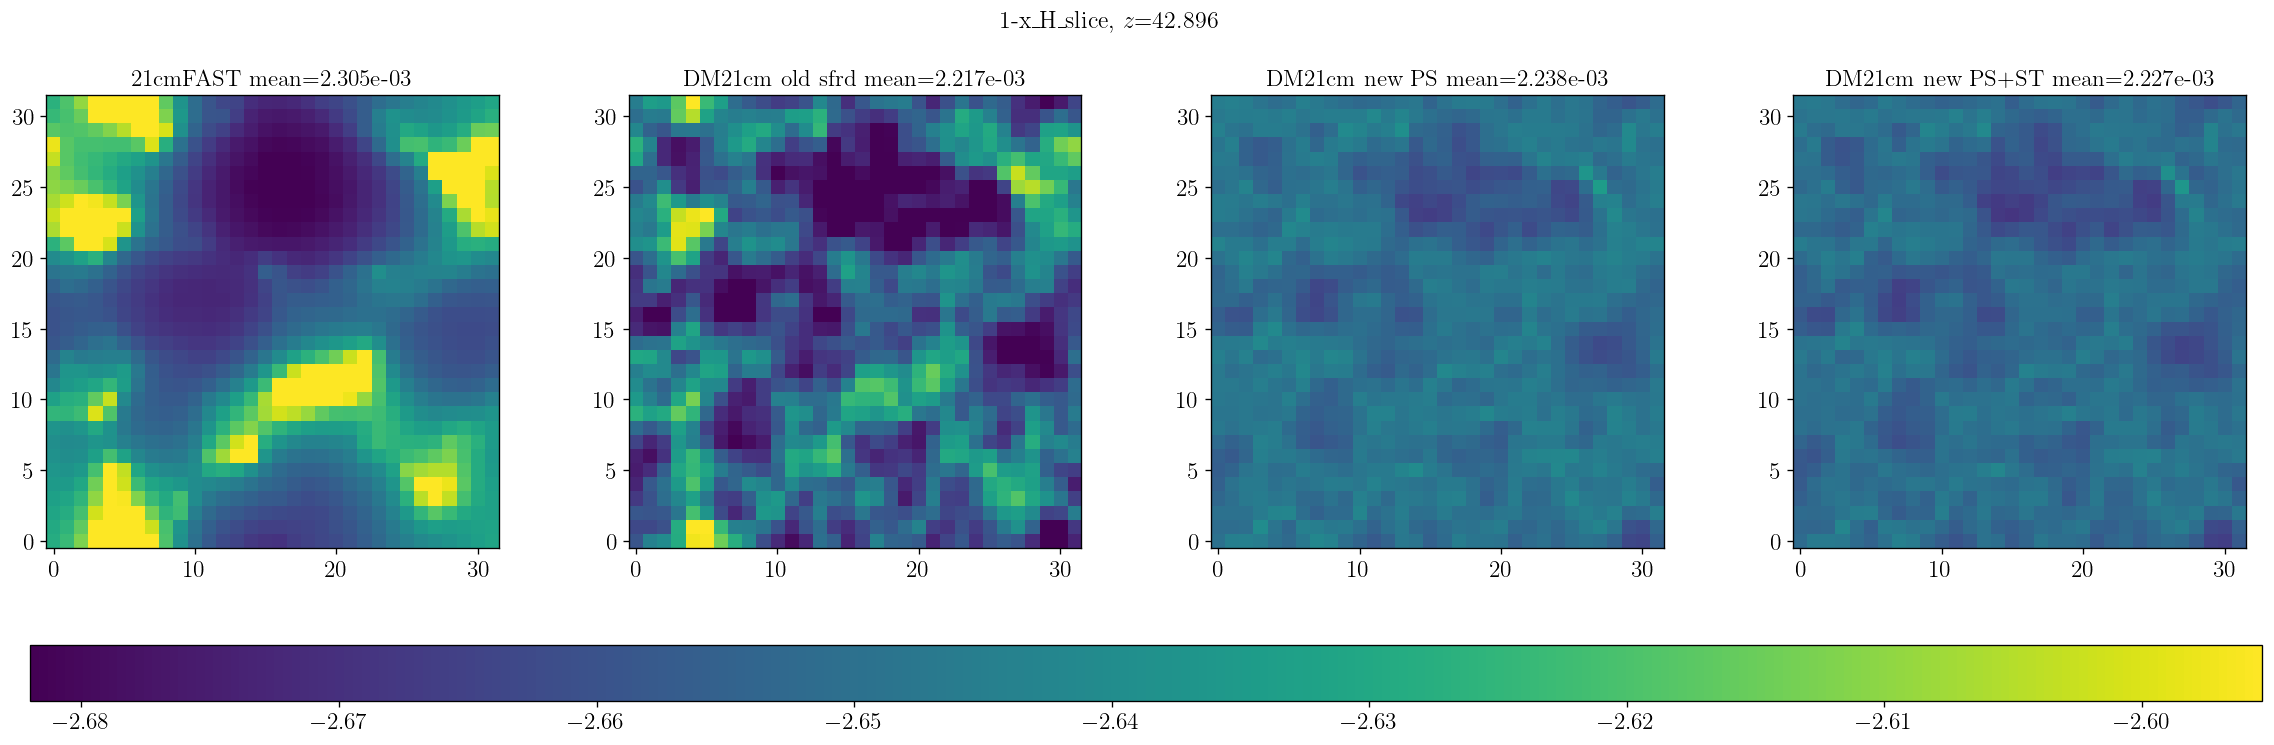

In [15]:
plot_silces_multi_runs(180, 'x_H_slice')

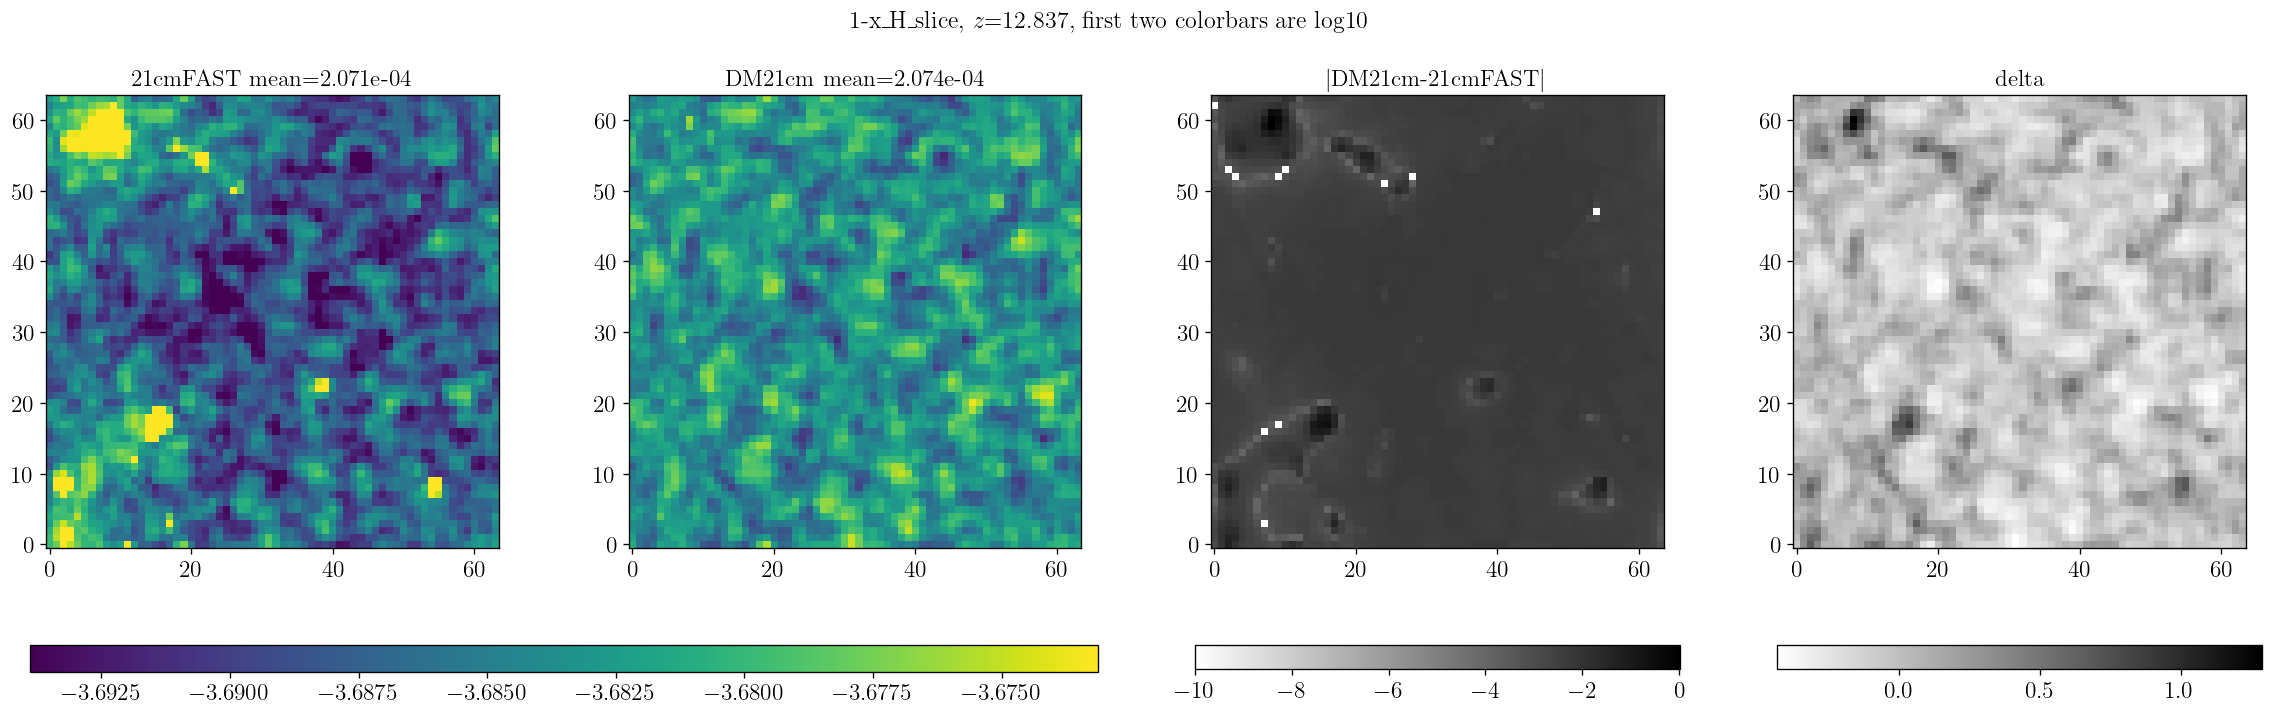

In [11]:
plot_silces(1200, 'x_H_slice')

In [12]:
for i in tqdm(np.arange(0, 2000, 50)):
    plot_silces(i, 'x_H_slice', save_fn=f"plots/slices/tmp/{i}.png")

100%|██████████| 40/40 [02:43<00:00,  4.08s/it]


In [9]:
from PIL import Image

def create_gif_from_filelist(file_list, output_gif_path, interval_time):
    images = [Image.open(file_path) for file_path in file_list]
    images[0].save(output_gif_path, save_all=True, append_images=images[1:], duration=interval_time * 1000, loop=0)

In [10]:
flist = []
for i in np.arange(0, 2000, 50):
    flist.append(f"plots/slices/tmp/{i}.png")

create_gif_from_filelist(flist, "x_H_zf001.gif", 0.5)

Text(0.5, 1.0, 'DM21cm')

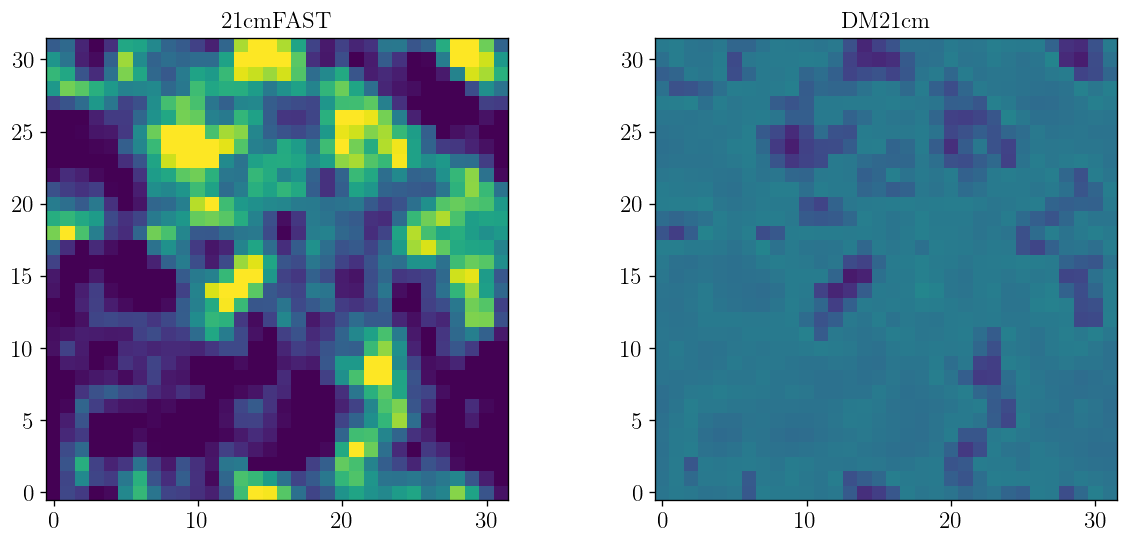

In [5]:
i = 180

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

ax = axs[0]
ax.imshow(np.log10(r_pc['x_e_slice'][i]), origin='lower', vmin=np.log10(r_pc['x_e'][i]*0.9), vmax=np.log10(r_pc['x_e'][i]*1.2))
ax.set_title('21cmFAST')

ax = axs[1]
ax.imshow(np.log10(r_dc['x_e_slice'][i]), origin='lower', vmin=np.log10(r_dc['x_e'][i]*0.9), vmax=np.log10(r_dc['x_e'][i]*1.2))
ax.set_title('DM21cm')

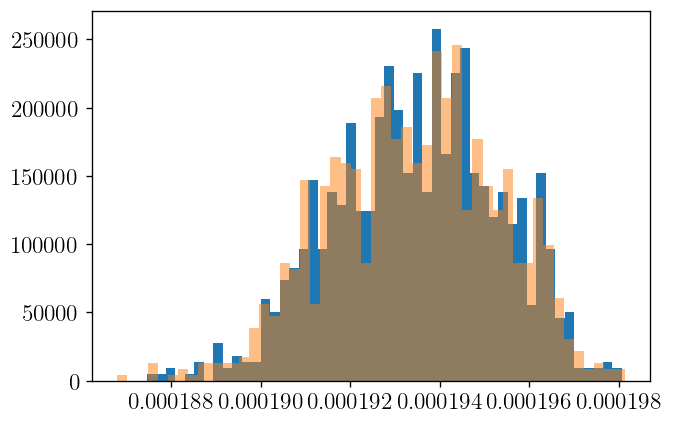

In [6]:
plt.hist((1-r_pc['x_H_slice'][100]).flatten(), bins=50, density=True)
plt.hist((1-r_dc['x_H_slice'][100]).flatten(), bins=50, alpha=0.5, density=True);

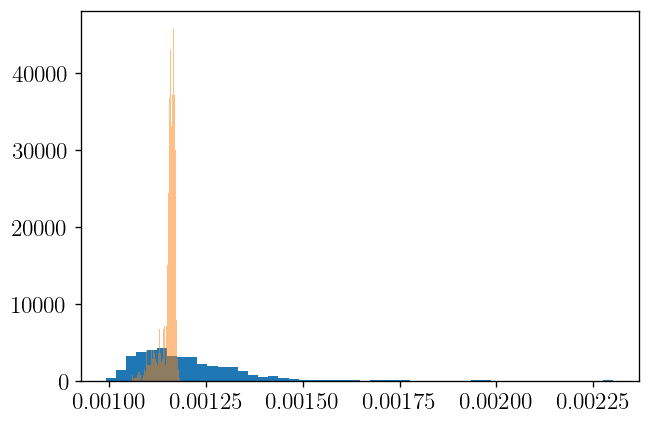

In [7]:
plt.hist((r_pc['x_e_slice'][180]).flatten(), bins=50, density=True)
plt.hist((r_dc['x_e_slice'][180]).flatten(), bins=50, alpha=0.5, density=True);

In [8]:
print(np.mean(r_dc['x_e_slice'][150]), r_dc['x_e'][150])
print(np.mean(r_pc['x_e_slice'][150]), r_pc['x_e'][150])

0.00031411526 0.00031383397
0.00032283572 0.00032448
